<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) - [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="https://colab.research.google.com/github/rmsrosa/modcovid19/blob/master/contents/notebooks/06.00.Aula-Modelos_baseados_em_individuos.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab" title="Open in Google Colab"></a>
&nbsp;<a href="https://mybinder.org/v2/gh/rmsrosa/modcovid19/master?filepath=contents/notebooks/06.00.Aula-Modelos_baseados_em_individuos.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Binder" title="Open in Binder"></a>
&nbsp;<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/master/contents/notebooks/06.00.Aula-Modelos_baseados_em_individuos.ipynb"><img align="left" src="https://img.shields.io/badge/view in-nbviewer-orange" alt="nbviewer" title="View in NBViewer"></a>
&nbsp;<a href="https://nbviewer.jupyter.org/github/rmsrosa/modcovid19/blob/master/contents/slides/06.00.Aula-Modelos_baseados_em_individuos.slides.html"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="slides" title="View Slides"></a>
&nbsp;<a href="https://raw.githubusercontent.com/rmsrosa/modcovid19/master/contents/notebooks/06.00.Aula-Modelos_baseados_em_individuos.ipynb"><img align="left" src="https://img.shields.io/badge/download-notebook-9cf" alt="download" title="Download Notebook"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Qualidade e comparação de modelos](05.00.Aula-Qualidade_e_comparacao_de_modelos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos indivuais estocásticos estruturados ->](07.00.Aula-Modelos_individuos_estruturados.ipynb)

---


# Modelos baseados em indivíuos e o relatório do Imperial Colege

- [Relatório do Imperial College de 16 de março](#Referências) que influenciou ações políticas no Reino Unido e no mundo (de 16 de março de 2020).

- Relatório produzido pelo **Grupo de Resposta sobre o COVID-19 do Imperial College** *(Imperial College COVID-19 Response Team)*.

- Apresenta resultados da modelagem epidemiológica incluindo intervenções não-farmaceuticas (e.g. sem vacinação), como distanciamento social e quarentena.

- Modelos do tipo **individual, estocástico, espacialmente estruturado e com evolução temporal discreta**.

**Importando bibliotecas e definindo funções a serem usadas abaixo**

In [1]:
import datetime as dt # date and time tools

from collections import namedtuple

from os import path

import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 16/Apr/2020


In [3]:
sns.set_style("darkgrid")

## Objetivos descritos no relatório

- O relatório analisou formas de ação considerando dois objetivos:

    - **Mitigação:** reduzir significativamente o número basico de reprodução $R_0 \gtrsim 1$.
    
        Visa **atrasar o crescimento da epidemia**, reduzindo a pressão no sistema de saúde e protegento os casos de risco. Mais objetivamente, procura-se 

    - **Supressão:** reduzir e manter o número basico de reprodução $R_0 <1$. 
    
        Visa **reverter o crescimento da epidemia**, reduzindo o número de casos a niveis baixos e mantendo-os baixos, indefinidamente. Mais objetivamente, procura-se 

## O modelo do Imperial College

Na seção de **Métodos**, os autores mencionam que modificaram modelos utilizados no estudo de influenza. Modelos do tipo **"baseado em indivíduo"** *(individual-based)* (também chamado comumente de "baseado em agente", ou *agent-based models*). Artigos mencionados:

- [Ferguson, Cummings, Fraser, Cajka, Cooley & Burke (2006)](#Referências).

- [Halloran et al (2008)](#Referências).


Outro trabalho ao qual cheguei a partir de [Ferguson et al (2006)](#Referências) e que entra um pouco mais em detalhes:

- [Ferguson et al (2005)](#Referências)

## Os modelos de referência

### Halloran et al (2008)

- Discussões do artigo [Halloran et al (2008)](#Referências) baseadas em três grupos de pesquisa:

    O artigo [Halloran et al (2008)](#Referências) menciona que as discussões em seu artigo são baseadas em resultados de três grupos apoiados em parte pelo [National Institutes of General Medical Sciences MIDAS network](https://www.nigms.nih.gov/Research/specificareas/Pages/default.aspx). 
    
- Os três usam **simulações estocásticas espacialmente estruturadas e com evolução temporal discreta** *(stochastic, spatially structured, individual-based discrete time simulations).* 

    Os detalhes variam de acordo com a estrutura social (veja [o suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1)).

### Ferguson et al (2006)

- No artigo do [Ferguson et al (2006)](#Referências), o modelo também é de **simulações estocásticas espacialmente estruturadas e com evolução temporal discreta**

    - Neste, o modelo trata **cada indivíduo de acordo com alguns núcleos de interação:**

        - ligações familiares
        - escolas
        - trabalho
        - encontros aleatórios com a população em geral
        - etc.

    - O modelo evolui de maneira **probabilística** e em **tempos discretos** (1/4 de um dia = 6 horas).

    - Simulações de **85 milhões de indivíduos** vivendo na Tailândia e em uma vizinhança de 100km em outros países.

    - Mais detalhes do modelo deste artigo nas [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).

## Modelos individuais estocásticos discretos no tempo

- Vamos começar com um modelo simples do tipo **SIR estocástico individual**.

- Baseado no exemplo de Keeling & Rohani (2007) para uma epidemia de **febre aftosa em gado** (**foot-and-mouth** disease, diferente da doença de pé-mão-boca em crianças).

- A febre-aftosa é **multi-espécie** (bovinos, caprinos, ovinos).

- Vamos **simplificar e considerar uma única espécie**, caso contrário deveríamos separar os diferentes parâmetros para cada espécia e cada interação entre espécies

- A doença é bastante letal e, nesse caso, $R$ inclui, em grande parte, **decessos**.

- Por conta disso, chamaremos $R$, mais geralmente, de **removidos**.

### Modelagem do estado do sistema

- Temos um **índice** $i=1, \ldots, N$ **para cada indivíduo**.

- O **estado do sistema** todo é representado por um vetor $\mathbf{x} = (x_1, \ldots, x_N)$ de dimensão $N$.

- Cada coordenada $x_i$ do vetor $\mathbf{x}$ representa o **estado do individuo** $i$.

- Cada indivíduo pode estar em um dos possívei estágios: **suscetível**, **infectado** ou **removido**..

- Representamos isso permitindo que $x_i$ assuma três valores, cada um correspondendo a um dos estágios:

    - $x_i=1:$ indivíduo $i$ **suscetível**;
    
    - $x_i=2:$ indivíduo $i$ **infectado**;
    
    - $x_i=3:$ indivíduo $i$ **removido**.

### Formas de interação: caso não estruturado

- Em geral:

    - Cada indivíduo interage com um certo número $\kappa$ de outros indivíduos, por unidade de tempo;

    - A infeção se dá a uma fração (probabilidade) $\mu$ de contágios por contato;

    - A taxa de contágio por indivíduo por unidade de tempo é $\beta = \mu\kappa$.

- No caso em que cada indivíduo está em contato com todos os outros:

    - $\kappa=N$;

    - $\mu = \beta/N$.
    
- No caso em que cada indivíduo está em contato com apenas um outro indivíduo, durante cada unidade de tempo (com esse indivíduo podendo mudar a cada passo de tempo):

    - $\kappa=1$;
    
    - $\mu = \beta$.

### Aleatoriedade


- A cada interação entre um indivíduo suscetível e um infectado, o contágio ocorre se um número aleatório for maior do que $\mu$.

- A distribuição de probabilidade desse número aleatório tem média $\mu$.

### Formas de interação: caso estruturado

- Os indivíduos estão localizados de diferentes formas:

    - Em uma região bidimensional;
    - Em vértice de uma rede;
    - Em um lattice.

- Interagem de acordo com o caso:

    - Dependendo da distância, de acordo com algum núcleo, em uma convolução;
    - De acordo com os vértices;
    - Com os seus vizinhos ou como um autômato celular.

### Recuperação ou remoção

Em qualquer dos casos:

- A recuperação/remoção se dá a uma taxa $\gamma$.

## Simulação no caso de um contato por pessoa por unidade de tempo

Nessa primeira simulação, vamos considerar que, durante cada passo discreto de tempo:

- Cada indivíduo está em contato com apenas um outro indivíduo.

- Mais precisamente, a cada passo de tempo, fazemos uma permutação aleatória da população e combinamos, dois a dois, a população com essa permutação.

- Em comparação com o SIR compartimental, temos $\kappa=1$ e $\mu = \beta$.

### Função de iteração

Iteração de cada indivíduo, por unidade de tempo, incluindo contágio e recuperação/remoção.

In [4]:
@np.vectorize
def iteracao(a, b, fator_de_recuperacao, fator_de_transmissao):
    if a == 2 and np.random.rand() < fator_de_recuperacao:
        a = 3
    elif a == 1 and b == 2 and np.random.rand() < fator_de_transmissao:
        a = 2
    return a

### Função de evolução diária

Evolui o estado completo da população, a cada unidade de tempo.

In [5]:
def evolui(populacao, fator_de_transmissao, fator_de_recuperacao):
    popalt = np.random.permutation(populacao)
    populacao = iteracao(populacao, popalt, fator_de_recuperacao, fator_de_transmissao)
    return populacao

### Exemplo de simulação

Definimos os parâmetros, as condições iniciais, evoluimos o sistema e exibimos os gráfico da evolução do número de casos em cada estágio da doença.

In [6]:
# parâmetros
fator_de_transmissao = 0.4 # (2.5 dias)^{-1} - gamma
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação -  mu

# estado inicial da população
num_individuos = 100
num_infectados0 = 2
populacao0 = np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = 2*np.ones(num_infectados0)
print(populacao0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [7]:
# simulação
tmax = 100
populacao = np.copy(populacao0)
num_infectados = np.array([num_infectados0])
num_suscetiveis = np.array([num_individuos - num_infectados0])
num_recuperados = np.array([0])
for t in range(1,tmax):
    populacao = evolui(np.copy(populacao), fator_de_transmissao, fator_de_recuperacao)
    num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==1)])
    num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==2)])
    num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])

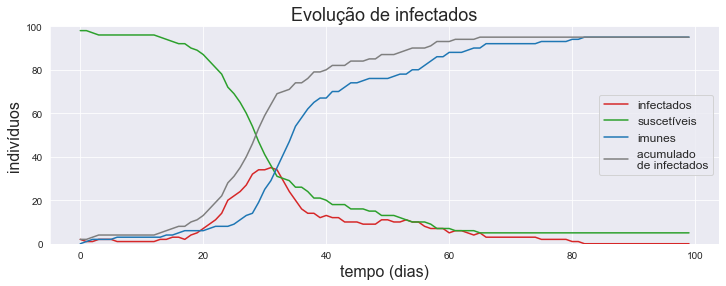

In [8]:
# visualização
plt.figure(figsize=(12,4))
plt.plot(num_infectados, '-', color='tab:red', label='infectados')
plt.plot(num_suscetiveis, '-', color='tab:green', label='suscetíveis')
plt.plot(num_recuperados, '-', color='tab:blue', label='imunes')
plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', label='acumulado \nde infectados')
plt.xlabel('tempo (dias)', fontsize=16)
plt.ylabel('indivíduos', fontsize=16)
plt.title('Evolução de infectados', fontsize=18)
plt.ylim(0, num_individuos)
plt.legend(fontsize=12)
plt.show()

### Simulações Monte-Carlo

O resultado anterior é, naturalmente, aleatório. Uma única simulação não é significativa.

Aqui, fazemos várias simulações para analisar o comportamento médio e o desvio-padrão da evolução de cada estágio.

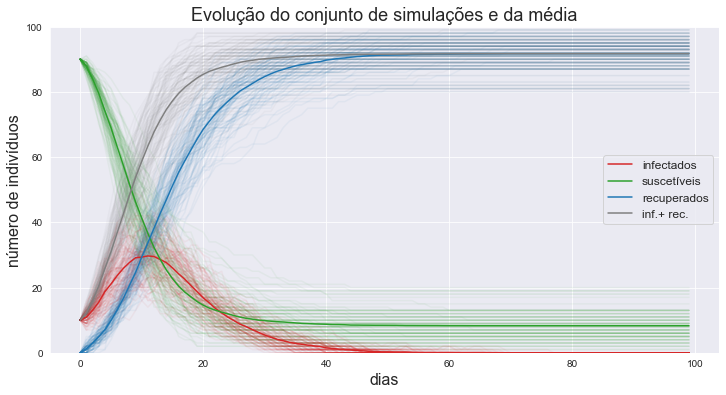

CPU times: user 3.36 s, sys: 69.5 ms, total: 3.43 s
Wall time: 3.54 s


In [9]:
%%time 
# parâmetros
fator_de_transmissao = 0.4
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação, em média

# estado inicial da população
num_individuos = 100
num_infectados0 = 10
populacao0 = np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = 2*np.ones(num_infectados0)

# dias para cada evolução
tmax = 100
dias = np.arange(tmax)

# número de simulações
num_simulacoes = 100

# alpha para os gráficos
alpha = min(0.2, 5/num_simulacoes)

# inicializa figura e define eixo vertical
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# inicializa variáveis para o cálculo da média
num_infectados_mean = np.zeros(num_individuos)
num_suscetiveis_mean = np.zeros(num_individuos)
num_recuperados_mean = np.zeros(num_individuos)
num_adoeceram_mean = np.zeros(num_individuos)

# inicializa variáveis para o cálculo do desvio padrão
sigma_infectados = np.zeros(num_individuos)
sigma_suscetiveis = np.zeros(num_individuos)
sigma_recuperados = np.zeros(num_individuos)
sigma_adoeceram = np.zeros(num_individuos)

# simulações
for k in range(num_simulacoes):
    # inicializa população de cada simulação
    populacao = np.copy(populacao0)
    num_infectados = np.array([num_infectados0])
    num_suscetiveis = np.array([num_individuos - num_infectados0])
    num_recuperados = np.array([0])
    num_adoeceram = np.array([0])
    
    # evolui o dia e armazena as novas contagens
    for t in range(1,tmax):
        populacao = evolui(populacao, fator_de_transmissao, fator_de_recuperacao)
        num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==1)])
        num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==2)])
        num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])
    
    # adiciona as contagens dessa simulação para o cálculo final da média
    num_infectados_mean += num_infectados
    num_suscetiveis_mean += num_suscetiveis
    num_recuperados_mean += num_recuperados
    num_adoeceram_mean += num_individuos - num_suscetiveis

    # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
    sigma_infectados += num_infectados ** 2
    sigma_suscetiveis += num_suscetiveis ** 2
    sigma_recuperados += num_recuperados ** 2
    sigma_adoeceram += (num_individuos - num_suscetiveis)**2
    
    # exibe os gráficos dos dados dessa simulação
    plt.plot(num_infectados, color='tab:red', alpha=alpha)
    plt.plot(num_suscetiveis, '-', color='tab:green', alpha=alpha)
    plt.plot(num_recuperados, '-', color='tab:blue', alpha=alpha)
    plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', alpha=alpha)

# divide pelo número de evoluções para obter a média, melhor fazer isso ao final
# para reduzir erros de arredondamento
num_infectados_mean /= num_simulacoes
num_suscetiveis_mean /= num_simulacoes
num_recuperados_mean /= num_simulacoes
num_adoeceram_mean /= num_simulacoes

# ajusta o calcula do desvio padrão
sigma_infectados = ( sigma_infectados / num_simulacoes - num_infectados_mean ** 2) ** .5
sigma_suscetiveis = ( sigma_suscetiveis / num_simulacoes - num_suscetiveis_mean ** 2 ) ** .5
sigma_recuperados = ( sigma_recuperados / num_simulacoes - num_recuperados_mean ** 2 ) ** .5
sigma_adoeceram = ( sigma_adoeceram / num_simulacoes - num_adoeceram_mean ** 2 ) ** .5

# exibe os gráficos das médias
plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução do conjunto de simulações e da média', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

### Incluindo desvio padrão na visualização

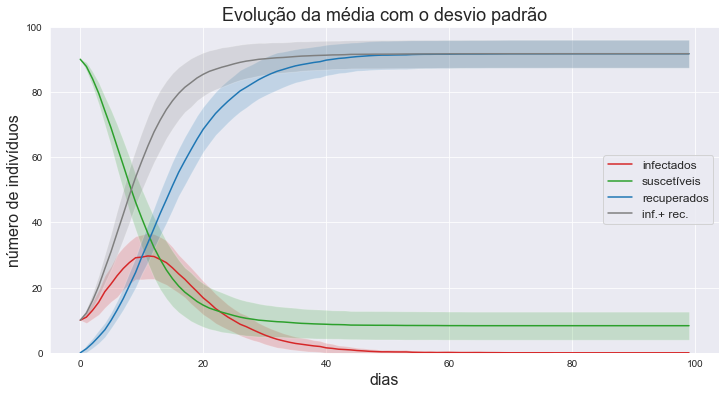

In [10]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.fill_between(dias, num_infectados_mean - sigma_infectados, num_infectados_mean + sigma_infectados, facecolor='tab:red', alpha = 0.2)

plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.fill_between(dias, num_suscetiveis_mean - sigma_suscetiveis, num_suscetiveis_mean + sigma_suscetiveis, facecolor='tab:green', alpha = 0.2)

plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.fill_between(dias, num_recuperados_mean - sigma_recuperados, num_recuperados_mean + sigma_recuperados, facecolor='tab:blue', alpha = 0.2)

plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')
plt.fill_between(dias, num_adoeceram_mean - sigma_adoeceram, num_adoeceram_mean + sigma_adoeceram, facecolor='tab:gray', alpha = 0.2)


# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução da média com o desvio padrão', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

### Comparação com o SIR compartimental determinístico

In [11]:
def taxa_de_evolucao(t, X, N, beta, gamma):
    S, I = X
    dXdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
    return dXdt

In [12]:
# população total
N = 100

# população inicial em cada estágio
R0 = 0 # recuperados/removidos
I0 = 10 # infectados
S0 = N - I0 - R0 # suscetíveis

# populacao inicial para o sistema reduzido
X0 = [S0, I0]

# parâmetros
beta = 0.4 # fator de transmissão
gamma = 0.15 # fator de recuperação

In [13]:
X = solve_ivp(taxa_de_evolucao, t_span=[0, tmax], y0 = X0, t_eval = dias, args=(N, beta, gamma))

S = X.y[0]
I = X.y[1]
R = N*np.ones_like(S) - S - I

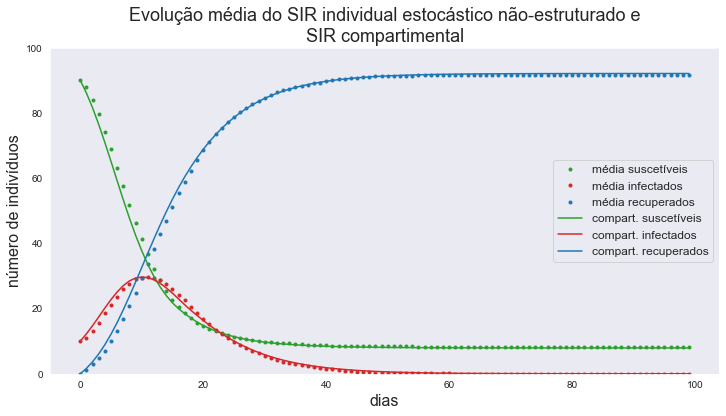

In [14]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# exibe os gráficos das médias
plt.plot(dias, num_suscetiveis_mean, '.', color='tab:green', label='média suscetíveis')
plt.plot(dias, num_infectados_mean, '.', color='tab:red', label='média infectados')
plt.plot(dias, num_recuperados_mean, '.', color='tab:blue', label='média recuperados')

plt.plot(dias, S, 'tab:green', label='compart. suscetíveis')
plt.plot(dias, I, 'tab:red', label='compart. infectados')
plt.plot(dias, R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução média do SIR individual estocástico não-estruturado e\nSIR compartimental', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show() 

## Modelando com uma rede completa de conexões

- Vamos fazer o outro extremo, com uma rede completa. 

- Esperamos o mesmo resultado, vamos conferir.

- Também inclui códigos necessários para tratar o caso estruturado.

- Criamos uma matriz $N\times N$, com número aleatórios entre $0$ e $1$.

- Os números na diagonal serão comparados com $\gamma$ para verificar a recuperação, ou remoção, de um indivíduo infectado.

- Os número fora da diagonal, em $i,j$, serão comparados com $\mu = \beta/N$ para verificar o contágio do indivíduo $i$, casa este seja suscetível e $j$ esteja infectado.

In [15]:
%timeit np.random.rand(100, 100)

147 µs ± 6.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
aux = np.copy(populacao)
%timeit np.select([aux==1], [aux])

63.8 µs ± 6.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
def evolui_grafo_completo(num_individuos, populacao, 
                          fator_de_transmissao, fator_de_recuperacao):
    A_random = np.random.rand(num_individuos, num_individuos)
    pop_aux = np.copy(populacao)
    pop_suscetiveis = np.select([pop_aux==1], [pop_aux])
    pop_infectados = np.select([pop_aux==2], [pop_aux])/2
    A_risco = np.tile(pop_infectados, (num_individuos, 1)) * A_random
    A_contatos = np.tile(pop_suscetiveis, (num_individuos, 1)).transpose() * A_risco
    A_infectados = np.select([A_contatos > 1 - fator_de_transmissao/num_individuos], [np.ones([num_individuos, num_individuos])])
    pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_individuos)])
    pop_recuperando = np.eye(num_individuos) * A_random @ pop_infectados
#    pop_recuperando = pop_infectados @ np.multiply(np.eye(num_individuos), A_random)
    pop_novos_recuperados = np.select([pop_recuperando > 1 - fator_de_recuperacao], [np.ones(num_individuos)])
    populacao_nova = pop_aux + pop_novos_infectados + pop_novos_recuperados
    
    return populacao_nova

In [ ]:
def evolui_grafo_estruturado(num_individuos, A_adj, num_edges_mean, populacao, 
                             fator_de_transmissao, fator_de_recuperacao):
    A_random = np.random.rand(num_individuos, num_individuos)
    A_graph_random = np.multiply(A_adj, A_random)
    pop_aux = np.copy(populacao)
    pop_suscetiveis = np.select([pop_aux==1], [pop_aux])
    pop_infectados = np.select([pop_aux==2], [pop_aux])/2
    A_risco = np.tile(pop_infectados, (num_individuos, 1)) * A_graph_random
    A_contatos = np.tile(pop_suscetiveis, (num_individuos, 1)).transpose() * A_risco
    A_infectados = np.select([A_contatos > 1 - fator_de_transmissao/num_edges_mean], [np.ones([num_individuos, num_individuos])])
    pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_individuos)])
    pop_novos_recuperados = np.select([pop_recuperando > 1 - fator_de_recuperacao], [np.ones(num_individuos)])
    populacao_nova = pop_aux + pop_novos_infectados + pop_novos_recuperados
    
    return populacao_nova

In [18]:
populacao0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.])

In [19]:
print('Fatores de transmissão:')
print(fator_de_transmissao/num_individuos)
print(np.exp(fator_de_transmissao/num_individuos)-1)
print()
print('Fatores de recuperação:')
print(fator_de_recuperacao/num_individuos)
print(np.exp(fator_de_recuperacao/num_individuos)-1)

Fatores de transmissão:
0.004
0.004008010677341911

Fatores de recuperação:
0.0015
0.001501125562711092


In [20]:
%timeit evolui_grafo_completo(num_individuos, populacao0, fator_de_transmissao, fator_de_recuperacao)

785 µs ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


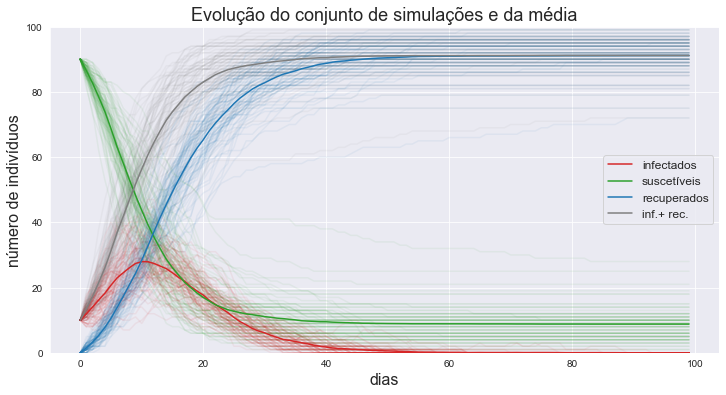

CPU times: user 6.63 s, sys: 64.5 ms, total: 6.7 s
Wall time: 6.82 s


In [48]:
%%time 
# parâmetros
fator_de_transmissao = 0.4
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação, em média

# estado inicial da população
num_individuos = 100
num_infectados0 = 10
populacao0 = np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = 2*np.ones(num_infectados0)

# dias para cada evolução
tmax = 100
dias = np.arange(tmax)

# número de simulações
num_simulacoes = 80

# alpha para os gráficos
alpha = min(0.2, 5/num_simulacoes)

# inicializa figura e define eixo vertical
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# inicializa variáveis para o cálculo da média
num_infectados_mean = np.zeros(num_individuos)
num_suscetiveis_mean = np.zeros(num_individuos)
num_recuperados_mean = np.zeros(num_individuos)
num_adoeceram_mean = np.zeros(num_individuos)

# inicializa variáveis para o cálculo do desvio padrão
sigma_infectados = np.zeros(num_individuos)
sigma_suscetiveis = np.zeros(num_individuos)
sigma_recuperados = np.zeros(num_individuos)
sigma_adoeceram = np.zeros(num_individuos)

# simulações
for k in range(num_simulacoes):
    # inicializa população de cada simulação
    populacao = np.copy(populacao0)
    num_infectados = np.array([num_infectados0])
    num_suscetiveis = np.array([num_individuos - num_infectados0])
    num_recuperados = np.array([0])
    num_adoeceram = np.array([0])
    
    # evolui o dia e armazena as novas contagens
    for t in range(1,tmax):
        populacao = evolui_grafo_completo(num_individuos, populacao, 
                                          fator_de_transmissao, fator_de_recuperacao)
        num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==1)])
        num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==2)])
        num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])
    
    # adiciona as contagens dessa simulação para o cálculo final da média
    num_infectados_mean += num_infectados
    num_suscetiveis_mean += num_suscetiveis
    num_recuperados_mean += num_recuperados
    num_adoeceram_mean += num_individuos - num_suscetiveis

    # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
    sigma_infectados += num_infectados ** 2
    sigma_suscetiveis += num_suscetiveis ** 2
    sigma_recuperados += num_recuperados ** 2
    sigma_adoeceram += (num_individuos - num_suscetiveis)**2
    
    # exibe os gráficos dos dados dessa simulação
    plt.plot(num_infectados, color='tab:red', alpha=alpha)
    plt.plot(num_suscetiveis, '-', color='tab:green', alpha=alpha)
    plt.plot(num_recuperados, '-', color='tab:blue', alpha=alpha)
    plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', alpha=alpha)

# divide pelo número de evoluções para obter a média, melhor fazer isso ao final
# para reduzir erros de arredondamento
num_infectados_mean /= num_simulacoes
num_suscetiveis_mean /= num_simulacoes
num_recuperados_mean /= num_simulacoes
num_adoeceram_mean /= num_simulacoes

# ajusta o calcula do desvio padrão
sigma_infectados = ( sigma_infectados / num_simulacoes - num_infectados_mean ** 2) ** .5
sigma_suscetiveis = ( sigma_suscetiveis / num_simulacoes - num_suscetiveis_mean ** 2 ) ** .5
sigma_recuperados = ( sigma_recuperados / num_simulacoes - num_recuperados_mean ** 2 ) ** .5
sigma_adoeceram = ( sigma_adoeceram / num_simulacoes - num_adoeceram_mean ** 2 ) ** .5

# exibe os gráficos das médias
plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução do conjunto de simulações e da média', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

In [22]:
aux = np.copy(populacao)
sus = np.select([aux==1], [aux])
inf = np.select([aux==2], [aux])
%timeit rem = np.select([aux==3], [aux])


74.4 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Visualização da média e do desvio padrão

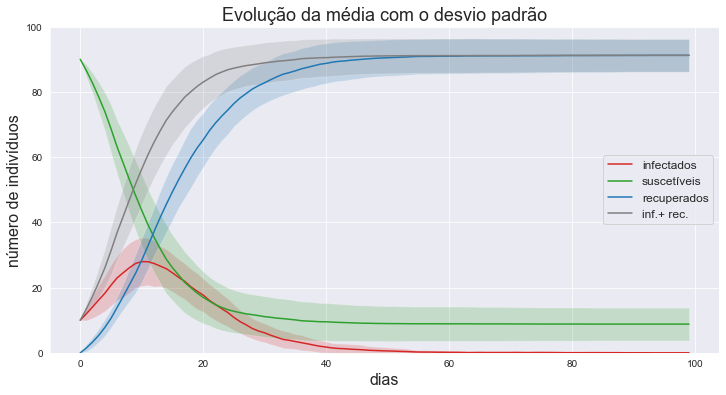

In [49]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.fill_between(dias, num_infectados_mean - sigma_infectados, num_infectados_mean + sigma_infectados, facecolor='tab:red', alpha = 0.2)

plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.fill_between(dias, num_suscetiveis_mean - sigma_suscetiveis, num_suscetiveis_mean + sigma_suscetiveis, facecolor='tab:green', alpha = 0.2)

plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.fill_between(dias, num_recuperados_mean - sigma_recuperados, num_recuperados_mean + sigma_recuperados, facecolor='tab:blue', alpha = 0.2)

plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')
plt.fill_between(dias, num_adoeceram_mean - sigma_adoeceram, num_adoeceram_mean + sigma_adoeceram, facecolor='tab:gray', alpha = 0.2)


# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução da média com o desvio padrão', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

### Comparação com o SIR compartimental determinístico

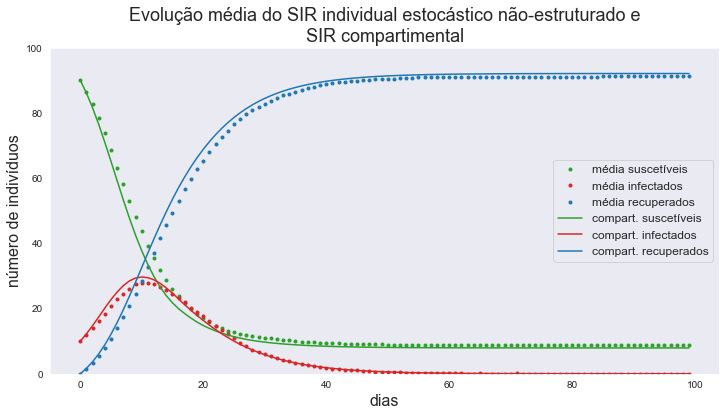

In [50]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# exibe os gráficos das médias
plt.plot(dias, num_suscetiveis_mean, '.', color='tab:green', label='média suscetíveis')
plt.plot(dias, num_infectados_mean, '.', color='tab:red', label='média infectados')
plt.plot(dias, num_recuperados_mean, '.', color='tab:blue', label='média recuperados')

plt.plot(dias, S, 'tab:green', label='compart. suscetíveis')
plt.plot(dias, I, 'tab:red', label='compart. infectados')
plt.plot(dias, R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução média do SIR individual estocástico não-estruturado e\nSIR compartimental', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show() 

## Exemplos com estrutura


In [515]:
def evolui_grafo_estruturado(num_individuos, A_adj, num_edges_mean, populacao, 
                             fator_de_transmissao, fator_de_recuperacao):
    A_random = np.random.rand(num_individuos, num_individuos)
    A_graph_random = np.multiply(A_adj, A_random)
    pop_aux = np.copy(populacao)
    pop_suscetiveis = np.select([pop_aux==1], [pop_aux])
    pop_infectados = np.select([pop_aux==2], [pop_aux])/2
    A_risco = np.multiply(np.tile(pop_infectados, (num_individuos, 1)), A_graph_random)
    A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_individuos, 1)).transpose(), A_risco)
    A_infectados = np.select([A_contatos > 1 - fator_de_transmissao/num_edges_mean], [np.ones([num_individuos, num_individuos])])
    pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_individuos)])
    pop_recuperando = pop_infectados @ np.multiply(np.eye(num_individuos), A_random)
    pop_novos_recuperados = np.select([pop_recuperando > 1 - fator_de_recuperacao], [np.ones(num_individuos)])
    populacao_nova = pop_aux + pop_novos_infectados + pop_novos_recuperados
    
    return populacao_nova

In [487]:
num_edges_mean = 5

In [488]:
G = nx.erdos_renyi_graph(num_individuos, num_edges_mean/num_individuos)

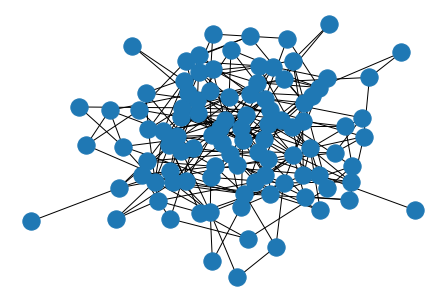

In [489]:
nx.draw(G)

In [466]:
A_adj = nx.to_numpy_matrix(G)

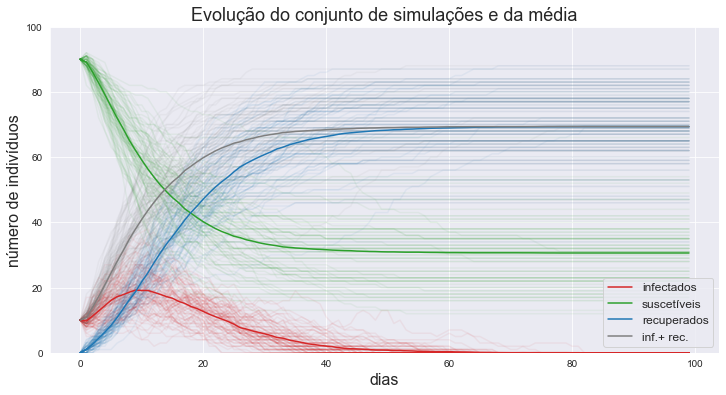

CPU times: user 7.62 s, sys: 81.3 ms, total: 7.7 s
Wall time: 8.11 s


In [516]:
%%time 
# parâmetros
fator_de_transmissao = 0.4
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação, em média

# estado inicial da população
num_individuos = 100
num_infectados0 = 10
populacao0 = np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = 2*np.ones(num_infectados0)

# dias para cada evolução
tmax = 100
dias = np.arange(tmax)

# número de simulações
num_simulacoes = 80

# alpha para os gráficos
alpha = min(0.2, 5/num_simulacoes)

# inicializa figura e define eixo vertical
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# inicializa variáveis para o cálculo da média
num_infectados_mean = np.zeros(num_individuos)
num_suscetiveis_mean = np.zeros(num_individuos)
num_recuperados_mean = np.zeros(num_individuos)
num_adoeceram_mean = np.zeros(num_individuos)

# inicializa variáveis para o cálculo do desvio padrão
sigma_infectados = np.zeros(num_individuos)
sigma_suscetiveis = np.zeros(num_individuos)
sigma_recuperados = np.zeros(num_individuos)
sigma_adoeceram = np.zeros(num_individuos)

# simulações
for k in range(num_simulacoes):
    # inicializa população de cada simulação
    populacao = np.copy(populacao0)
    num_infectados = np.array([num_infectados0])
    num_suscetiveis = np.array([num_individuos - num_infectados0])
    num_recuperados = np.array([0])
    num_adoeceram = np.array([0])
    
    # evolui o dia e armazena as novas contagens
    for t in range(1,tmax):
        populacao = evolui_grafo_estruturado(num_individuos, A_adj, num_edges_mean, populacao,
                                             fator_de_transmissao, fator_de_recuperacao)
        num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==1)])
        num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==2)])
        num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])
    
    # adiciona as contagens dessa simulação para o cálculo final da média
    num_infectados_mean += num_infectados
    num_suscetiveis_mean += num_suscetiveis
    num_recuperados_mean += num_recuperados
    num_adoeceram_mean += num_individuos - num_suscetiveis

    # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
    sigma_infectados += num_infectados ** 2
    sigma_suscetiveis += num_suscetiveis ** 2
    sigma_recuperados += num_recuperados ** 2
    sigma_adoeceram += (num_individuos - num_suscetiveis)**2
    
    # exibe os gráficos dos dados dessa simulação
    plt.plot(num_infectados, color='tab:red', alpha=alpha)
    plt.plot(num_suscetiveis, '-', color='tab:green', alpha=alpha)
    plt.plot(num_recuperados, '-', color='tab:blue', alpha=alpha)
    plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', alpha=alpha)

# divide pelo número de evoluções para obter a média, melhor fazer isso ao final
# para reduzir erros de arredondamento
num_infectados_mean /= num_simulacoes
num_suscetiveis_mean /= num_simulacoes
num_recuperados_mean /= num_simulacoes
num_adoeceram_mean /= num_simulacoes

# ajusta o calcula do desvio padrão
sigma_infectados = ( sigma_infectados / num_simulacoes - num_infectados_mean ** 2) ** .5
sigma_suscetiveis = ( sigma_suscetiveis / num_simulacoes - num_suscetiveis_mean ** 2 ) ** .5
sigma_recuperados = ( sigma_recuperados / num_simulacoes - num_recuperados_mean ** 2 ) ** .5
sigma_adoeceram = ( sigma_adoeceram / num_simulacoes - num_adoeceram_mean ** 2 ) ** .5

# exibe os gráficos das médias
plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução do conjunto de simulações e da média', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

### Comparação com o SIR compartimental determinístico

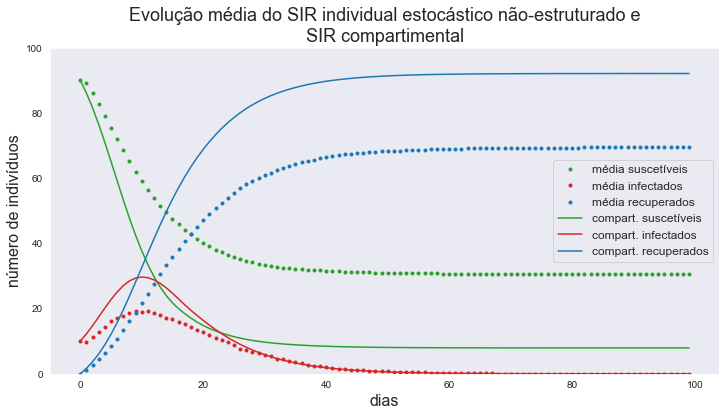

In [517]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# exibe os gráficos das médias
plt.plot(dias, num_suscetiveis_mean, '.', color='tab:green', label='média suscetíveis')
plt.plot(dias, num_infectados_mean, '.', color='tab:red', label='média infectados')
plt.plot(dias, num_recuperados_mean, '.', color='tab:blue', label='média recuperados')

plt.plot(dias, S, 'tab:green', label='compart. suscetíveis')
plt.plot(dias, I, 'tab:red', label='compart. infectados')
plt.plot(dias, R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução média do SIR individual estocástico não-estruturado e\nSIR compartimental', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show() 

In [483]:
nx.average_degree_connectivity(G2)

{44: 44.02272727272727, 45: 43.06666666666667, 2: 6.3}

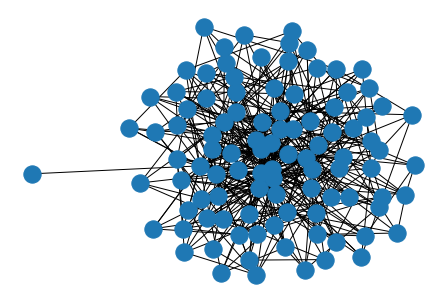

In [523]:
G = nx.barabasi_albert_graph(num_individuos, num_edges_mean, 0)
nx.draw(G)
A_adj = nx.to_numpy_matrix(G)

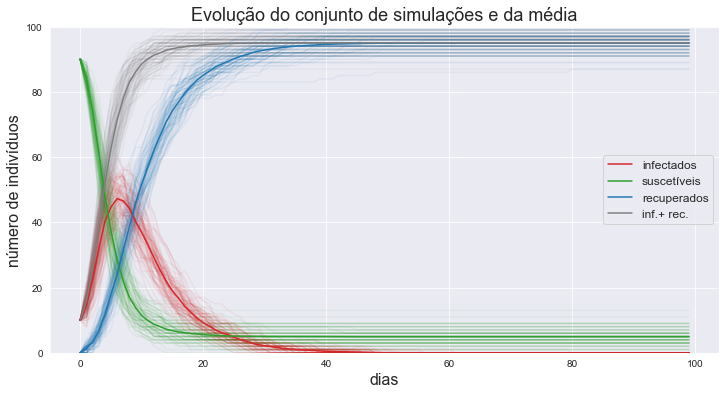

CPU times: user 7.76 s, sys: 98.2 ms, total: 7.85 s
Wall time: 8.32 s


In [524]:
%%time 
# parâmetros
fator_de_transmissao = 0.4
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação, em média

# estado inicial da população
num_individuos = 100
num_infectados0 = 10
populacao0 = np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = 2*np.ones(num_infectados0)

# dias para cada evolução
tmax = 100
dias = np.arange(tmax)

# número de simulações
num_simulacoes = 80

# alpha para os gráficos
alpha = min(0.2, 5/num_simulacoes)

# inicializa figura e define eixo vertical
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# inicializa variáveis para o cálculo da média
num_infectados_mean = np.zeros(num_individuos)
num_suscetiveis_mean = np.zeros(num_individuos)
num_recuperados_mean = np.zeros(num_individuos)
num_adoeceram_mean = np.zeros(num_individuos)

# inicializa variáveis para o cálculo do desvio padrão
sigma_infectados = np.zeros(num_individuos)
sigma_suscetiveis = np.zeros(num_individuos)
sigma_recuperados = np.zeros(num_individuos)
sigma_adoeceram = np.zeros(num_individuos)

# simulações
for k in range(num_simulacoes):
    # inicializa população de cada simulação
    populacao = np.copy(populacao0)
    num_infectados = np.array([num_infectados0])
    num_suscetiveis = np.array([num_individuos - num_infectados0])
    num_recuperados = np.array([0])
    num_adoeceram = np.array([0])
    
    # evolui o dia e armazena as novas contagens
    for t in range(1,tmax):
        populacao = evolui_grafo_estruturado(num_individuos, A_adj, num_edges_mean, populacao,
                                             fator_de_transmissao, fator_de_recuperacao)
        num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==1)])
        num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==2)])
        num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])
    
    # adiciona as contagens dessa simulação para o cálculo final da média
    num_infectados_mean += num_infectados
    num_suscetiveis_mean += num_suscetiveis
    num_recuperados_mean += num_recuperados
    num_adoeceram_mean += num_individuos - num_suscetiveis

    # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
    sigma_infectados += num_infectados ** 2
    sigma_suscetiveis += num_suscetiveis ** 2
    sigma_recuperados += num_recuperados ** 2
    sigma_adoeceram += (num_individuos - num_suscetiveis)**2
    
    # exibe os gráficos dos dados dessa simulação
    plt.plot(num_infectados, color='tab:red', alpha=alpha)
    plt.plot(num_suscetiveis, '-', color='tab:green', alpha=alpha)
    plt.plot(num_recuperados, '-', color='tab:blue', alpha=alpha)
    plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', alpha=alpha)

# divide pelo número de evoluções para obter a média, melhor fazer isso ao final
# para reduzir erros de arredondamento
num_infectados_mean /= num_simulacoes
num_suscetiveis_mean /= num_simulacoes
num_recuperados_mean /= num_simulacoes
num_adoeceram_mean /= num_simulacoes

# ajusta o calcula do desvio padrão
sigma_infectados = ( sigma_infectados / num_simulacoes - num_infectados_mean ** 2) ** .5
sigma_suscetiveis = ( sigma_suscetiveis / num_simulacoes - num_suscetiveis_mean ** 2 ) ** .5
sigma_recuperados = ( sigma_recuperados / num_simulacoes - num_recuperados_mean ** 2 ) ** .5
sigma_adoeceram = ( sigma_adoeceram / num_simulacoes - num_adoeceram_mean ** 2 ) ** .5

# exibe os gráficos das médias
plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução do conjunto de simulações e da média', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

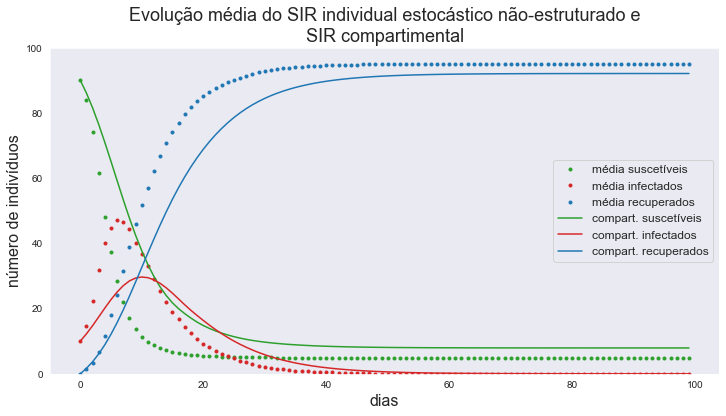

In [525]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# exibe os gráficos das médias
plt.plot(dias, num_suscetiveis_mean, '.', color='tab:green', label='média suscetíveis')
plt.plot(dias, num_infectados_mean, '.', color='tab:red', label='média infectados')
plt.plot(dias, num_recuperados_mean, '.', color='tab:blue', label='média recuperados')

plt.plot(dias, S, 'tab:green', label='compart. suscetíveis')
plt.plot(dias, I, 'tab:red', label='compart. infectados')
plt.plot(dias, R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução média do SIR individual estocástico não-estruturado e\nSIR compartimental', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show() 

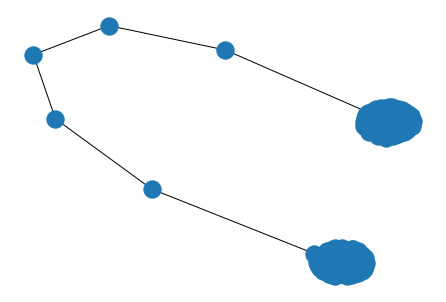

In [543]:
G = nx.barbell_graph(num_individuos, num_edges_mean)
nx.draw(G)

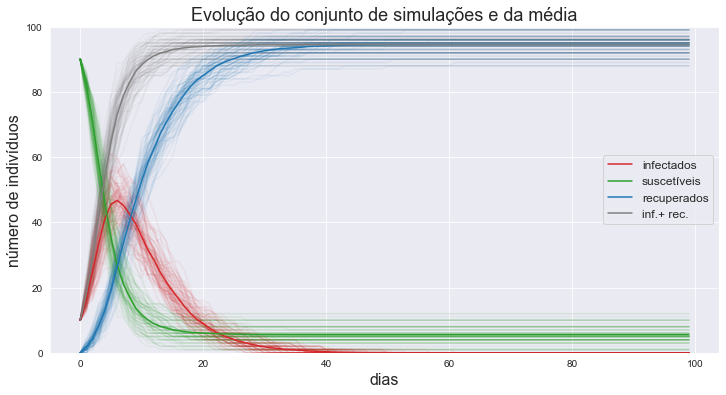

CPU times: user 7.71 s, sys: 96.8 ms, total: 7.81 s
Wall time: 8.15 s


In [544]:
%%time 
# parâmetros
fator_de_transmissao = 0.4
fator_de_recuperacao = 0.15 # entre seis e sete dias de recuperação, em média

# estado inicial da população
num_individuos = 100
num_infectados0 = 10
populacao0 = np.ones(num_individuos)
infectados0 = np.random.choice(num_individuos, num_infectados0)
populacao0[infectados0] = 2*np.ones(num_infectados0)

# dias para cada evolução
tmax = 100
dias = np.arange(tmax)

# número de simulações
num_simulacoes = 80

# alpha para os gráficos
alpha = min(0.2, 5/num_simulacoes)

# inicializa figura e define eixo vertical
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# inicializa variáveis para o cálculo da média
num_infectados_mean = np.zeros(num_individuos)
num_suscetiveis_mean = np.zeros(num_individuos)
num_recuperados_mean = np.zeros(num_individuos)
num_adoeceram_mean = np.zeros(num_individuos)

# inicializa variáveis para o cálculo do desvio padrão
sigma_infectados = np.zeros(num_individuos)
sigma_suscetiveis = np.zeros(num_individuos)
sigma_recuperados = np.zeros(num_individuos)
sigma_adoeceram = np.zeros(num_individuos)

# simulações
for k in range(num_simulacoes):
    # inicializa população de cada simulação
    populacao = np.copy(populacao0)
    num_infectados = np.array([num_infectados0])
    num_suscetiveis = np.array([num_individuos - num_infectados0])
    num_recuperados = np.array([0])
    num_adoeceram = np.array([0])
    
    # evolui o dia e armazena as novas contagens
    for t in range(1,tmax):
        populacao = evolui_grafo_estruturado(num_individuos, A_adj, num_edges_mean, populacao,
                                             fator_de_transmissao, fator_de_recuperacao)
        num_suscetiveis = np.hstack([num_suscetiveis, np.count_nonzero(populacao==1)])
        num_infectados = np.hstack([num_infectados, np.count_nonzero(populacao==2)])
        num_recuperados = np.hstack([num_recuperados, np.count_nonzero(populacao==3)])
    
    # adiciona as contagens dessa simulação para o cálculo final da média
    num_infectados_mean += num_infectados
    num_suscetiveis_mean += num_suscetiveis
    num_recuperados_mean += num_recuperados
    num_adoeceram_mean += num_individuos - num_suscetiveis

    # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
    sigma_infectados += num_infectados ** 2
    sigma_suscetiveis += num_suscetiveis ** 2
    sigma_recuperados += num_recuperados ** 2
    sigma_adoeceram += (num_individuos - num_suscetiveis)**2
    
    # exibe os gráficos dos dados dessa simulação
    plt.plot(num_infectados, color='tab:red', alpha=alpha)
    plt.plot(num_suscetiveis, '-', color='tab:green', alpha=alpha)
    plt.plot(num_recuperados, '-', color='tab:blue', alpha=alpha)
    plt.plot(num_individuos - num_suscetiveis, '-', color='tab:gray', alpha=alpha)

# divide pelo número de evoluções para obter a média, melhor fazer isso ao final
# para reduzir erros de arredondamento
num_infectados_mean /= num_simulacoes
num_suscetiveis_mean /= num_simulacoes
num_recuperados_mean /= num_simulacoes
num_adoeceram_mean /= num_simulacoes

# ajusta o calcula do desvio padrão
sigma_infectados = ( sigma_infectados / num_simulacoes - num_infectados_mean ** 2) ** .5
sigma_suscetiveis = ( sigma_suscetiveis / num_simulacoes - num_suscetiveis_mean ** 2 ) ** .5
sigma_recuperados = ( sigma_recuperados / num_simulacoes - num_recuperados_mean ** 2 ) ** .5
sigma_adoeceram = ( sigma_adoeceram / num_simulacoes - num_adoeceram_mean ** 2 ) ** .5

# exibe os gráficos das médias
plt.plot(dias, num_infectados_mean, '-', color='tab:red', label='infectados')
plt.plot(dias, num_suscetiveis_mean, '-', color='tab:green', label='suscetíveis')
plt.plot(dias, num_recuperados_mean, '-', color='tab:blue', label='recuperados')
plt.plot(dias, num_adoeceram_mean, '-', color='tab:gray', label='inf.+ rec.')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução do conjunto de simulações e da média', fontsize=18)
plt.legend(fontsize=12)
plt.show() 

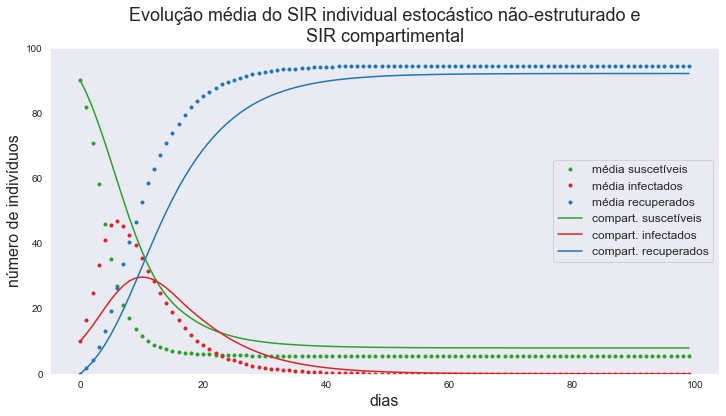

In [545]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_individuos)

# exibe os gráficos das médias
plt.plot(dias, num_suscetiveis_mean, '.', color='tab:green', label='média suscetíveis')
plt.plot(dias, num_infectados_mean, '.', color='tab:red', label='média infectados')
plt.plot(dias, num_recuperados_mean, '.', color='tab:blue', label='média recuperados')

plt.plot(dias, S, 'tab:green', label='compart. suscetíveis')
plt.plot(dias, I, 'tab:red', label='compart. infectados')
plt.plot(dias, R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução média do SIR individual estocástico não-estruturado e\nSIR compartimental', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show() 

# Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020. (Free Download)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52. (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/) 

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic
in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).)

- [Halloran ME, Ferguson NM, Eubank S, et al (2008), Modeling targeted layered containment of an influenza pandemic in the United States. Proc Natl Acad Sci U S A 105 (12), 4639–44 (Free Download).](https://pubmed.ncbi.nlm.nih.gov/18332436/) (Veja, também, o [suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1))

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)

Veja a página [Imperial College - Covid 19](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/) para mais relatórios, publicações e outras informações do Imperial College.

## Grafos

Veja [Geometric graph](https://networkx.github.io/documentation/latest/auto_examples/drawing/plot_random_geometric_graph.html#sphx-glr-auto-examples-drawing-plot-random-geometric-graph-py) para fixar a geometria do grafo, para visualizaçõe da evolução geoespacial da epidemia. 

Acho que o que precisamos, na verdade, é do comando [pos = nx.get_node_attributes(G, "pos")]()

Veja [tutorial](https://networkx.github.io/documentation/networkx-1.9/tutorial/tutorial.html#graph-attributes) para gerar gráficos.

In [37]:
!jupyter nbconvert 06.00-Modelos_baseados_em_individuos.ipynb --to slides --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 06.00-Modelos_baseados_em_individuos.ipynb to slides
[NbConvertApp] Writing 1347260 bytes to 06.00-Modelos_baseados_em_individuos.slides.html


<!--NAVIGATOR-->

---
[<- Qualidade e comparação de modelos](05.00.Aula-Qualidade_e_comparacao_de_modelos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos indivuais estocásticos estruturados ->](07.00.Aula-Modelos_individuos_estruturados.ipynb)